# Countermeasures model v1

Changes:
* Fixed convolution by creating a tested library version
* Cleared up import code, removed obsolete mask, added text cells
* Improve plotting & writeouts
* Renamed from "basic" to v1 (this is hardly a simple model)
* Use exp(-gamma) as CMReduction prior
* Use Active in place of Confirmed for exp growth
* Transform to log space (much more stable!)
* Use Half-cauchy hyperprior for DailyGrowth variance
* Use more countries (from model description doc)
* Update to `countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv` features
* Update countries to Jan Brauner's rec. [here](https://epidemicforecasting.slack.com/archives/C010KK204TG/p1587753717310600) (minus JK's comments)

## Import & initialization

In [1]:
### Initial imports
%load_ext autoreload
%autoreload 2

import datetime
import io
import logging
from pathlib import Path

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel import RegionDataset, read_csv, Level
from epimodel.pymc3_models.utils import geom_convolution, convolution
from epimodel.pymc3_models import cm_effect

## Loading data and parameter settings

[2020-04-24 23:10:10,881] INFO(epimodel.regions): Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
[2020-04-24 23:10:11,197] INFO(numexpr.utils): NumExpr defaulting to 4 threads.



Countermeasures                            min   .. mean  .. max
 0 Gatherings limited to 10                   0.000 .. 0.100 .. 1.000  {0.0, 1.0}
 1 Gatherings limited to 100                  0.000 .. 0.189 .. 1.000  {0.0, 1.0}
 2 Gatherings limited to 1000                 0.000 .. 0.212 .. 1.000  {0.0, 1.0}
 3 Business suspended - some                  0.000 .. 0.224 .. 1.000  {0.0, 1.0}
 4 Business suspended - many                  0.000 .. 0.137 .. 1.000  {0.0, 1.0}
 5 Schools and universities closed            0.000 .. 0.318 .. 1.000  {0.0, 1.0}
 6 General curfew                             0.000 .. 0.096 .. 1.000  {0.0, 1.0}
 7 Healthcare specialisation                  0.000 .. 0.036 .. 1.000  {0.0, 1.0}
 8 Mask wearing over 70%                      0.000 .. 0.051 .. 1.000  {0.0, 1.0}


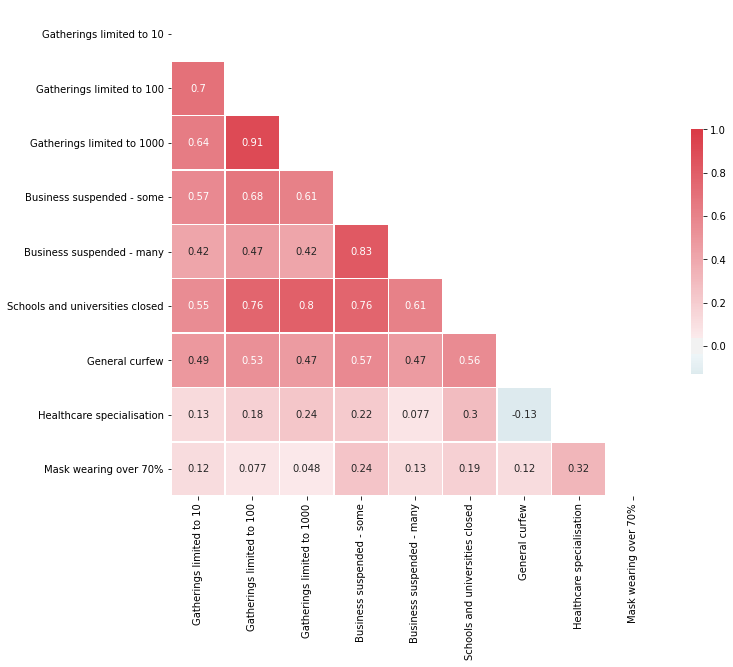

In [3]:
# From https://epidemicforecasting.slack.com/archives/C010KK204TG/p1587753717310600
# Removing by JK recommendation

Cs = ['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 
      'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT',
      'LT', 'MA', 'MX', 'NL', 'PL', 'RO', 'RS', 'SE', 'SG', 'SI',
      'SK', 'ZA']
## Note: leaving out 'MY' since it has no data
nCs = len(Cs)

CMs = ["Gatherings limited to 10", "Gatherings limited to 100", "Gatherings limited to 1000",
       "Business suspended - some", "Business suspended - many",
       "Schools and universities closed", "General curfew",
       "Healthcare specialisation", "Mask wearing over 70%"]
nCMs = len(CMs)

CMDelayCut = 10
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])

data = cm_effect.Loader('2020-02-15', '2020-04-15', Cs, CMs, active_cm_file='countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv')
data.print_stats()
Ds = data.Ds
nDs = len(data.Ds)

ActiveCMs = data.get_ActiveCMs(pd.date_range(
    start=data.Ds[0]-pd.DateOffset(days=CMDelayCut), end=data.Ds[-1], tz="utc"))
Confirmed = data.Confirmed
Active = data.Active

def statstr(d):
    return f"{d.mean():.3g} ({np.quantile(d, 0.05):.3g} .. {np.quantile(d, 0.95):.3g})"

def plot_CM_correlation(CMs, ActiveCMs, DelayProb):
    dcs = {}
    for cmi, cm in enumerate(CMs):
        dcs[cm] = []
        for ci in range(nCs):
            dcs[cm].extend(np.convolve(ActiveCMs[ci, cmi, :], DelayProb))
    dcs = pd.DataFrame(dcs)
    corr = dcs.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, center=0, annot=True,
                square=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5})

plot_CM_correlation(CMs, ActiveCMs, DelayProb)

## Model definition

In [4]:
## !!! (almost) All variables below are in Log-space !!!!

with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    #BaseGrowthRate = pm.Normal("BaseGrowthRate", np.log(1.2), 2.0)
    
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Normal("InitialSize", 0.0, 10, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Normal("CountryGrowthRate", np.log(1.2), 0.3, shape=(nCs,))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReductionGamma = pm.Gamma("CMReductionGamma", 0.5, 1.0, shape=(nCMs,))
    CMReduction = pm.Deterministic("CMReduction", T.exp((-1.0) * CMReductionGamma))

    # [country, CM, day + CMDelayCut] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReductionGamma, (1, nCMs, 1)) * ActiveCMs
    
    # [country, day + CMDelayCut] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.sum(ActiveCMReduction, axis=1))

    # [country, day + CMDelayCut] Convolution of GrowthReduction by DelayProb along days
    DelayedGrowthReduction = convolution(GrowthReduction, DelayProb, axis=1)

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day] The ideal predicted daily growth
    PredictedGrowth = pm.Deterministic("PredictedGrowth",
        T.reshape(CountryGrowthRate, (nCs, 1)) - DelayedGrowthReduction)
    
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Normal("DailyGrowth", PredictedGrowth, 0.1, shape=(nCs, nDs))

    # Below I assume plain exponentia growth of Active rather than e.g. depending on the remaining
    # susceptible opulation etc.

    # [country, day] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) + DailyGrowth.cumsum(axis=1))

    # [country, day] Cummulative tested positives
    Observed = pm.Normal("Observed", Size, 0.4, shape=(nCs, nDs), observed=np.log(Active))

/home/gavento/proj/.venv/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning:

Data in Observed contains missing values and will be automatically imputed from the sampling distribution.



## Run MCMC inference

1000 steps is enough for seeing the convergence and rough results, more is better, though.

In [5]:
print(model.check_test_point())
with model:
    trace = pm.sample(2000, chains=2, cores=2, init='adapt_diag')

[2020-04-24 23:11:51,918] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-04-24 23:11:51,919] INFO(pymc3): Initializing NUTS using adapt_diag...


InitialSize                  -106.31
CountryGrowthRate               9.41
CMReductionGamma_log__        -12.77
DailyGrowth                  2785.28
Observed_missing                0.00
Observed                 -6006749.23
Name: Log-probability of test_point, dtype: float64


[2020-04-24 23:12:50,996] INFO(pymc3): Multiprocess sampling (2 chains in 2 jobs)
[2020-04-24 23:12:50,997] INFO(pymc3): NUTS: [Observed_missing, DailyGrowth, CMReductionGamma, CountryGrowthRate, InitialSize]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [03:59<00:00, 20.88draws/s]
[2020-04-24 23:17:10,171] ERROR(pymc3): The estimated number of effective samples is smaller than 200 for some parameters.


## Plot chain stability

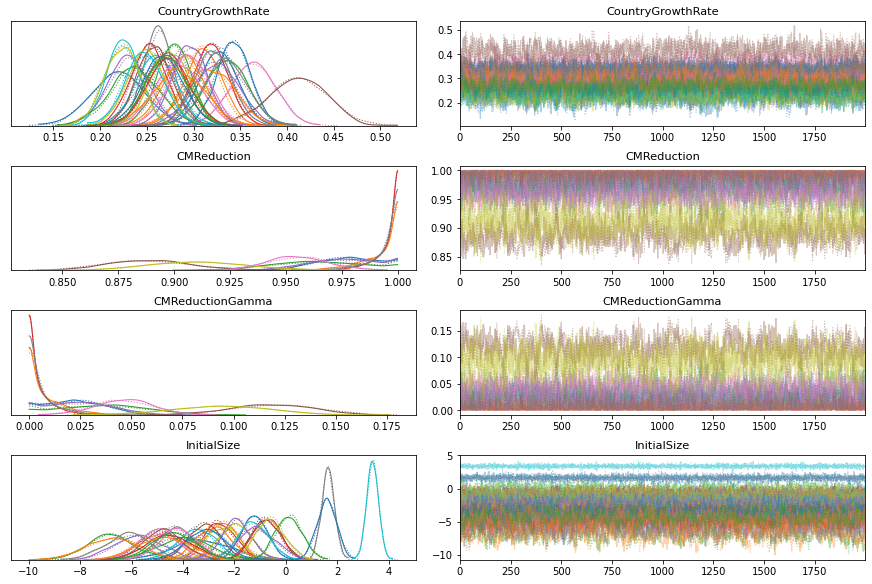

In [6]:
_ = pm.traceplot(trace, var_names=["CountryGrowthRate", "CMReduction", "CMReductionGamma", "InitialSize"])

## Plot inferred countermeasure effect

Effects are multiplicative (e.g. for a countermeasure that is a strenghtening of another, the inferred strenght is the additional multiplier).

The countermeasure strength is the multiplicative effect at feature=1.0.

 0 Gatherings limited to 10                 CMReduction 0.977 (0.954 .. 0.998)
 1 Gatherings limited to 100                CMReduction 0.992 (0.973 .. 1)
 2 Gatherings limited to 1000               CMReduction 0.965 (0.93 .. 0.998)
 3 Business suspended - some                CMReduction 0.995 (0.982 .. 1)
 4 Business suspended - many                CMReduction 0.975 (0.949 .. 0.998)
 5 Schools and universities closed          CMReduction 0.888 (0.858 .. 0.919)
 6 General curfew                           CMReduction 0.955 (0.933 .. 0.979)
 7 Healthcare specialisation                CMReduction 0.994 (0.977 .. 1)
 8 Mask wearing over 70%                    CMReduction 0.911 (0.875 .. 0.949)


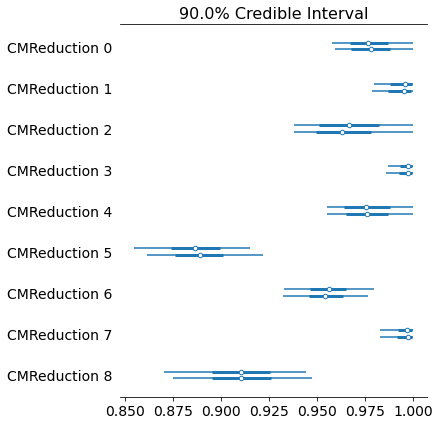

In [7]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReduction {statstr(trace['CMReduction'][:,i])}")

Cummulated CM effects
 0 Gatherings limited to 10                 CMReductionC 0.934 (0.902 .. 0.965)
 1 Gatherings limited to 100                CMReductionC 0.957 (0.923 .. 0.989)
 2 Gatherings limited to 1000               CMReductionC 0.965 (0.93 .. 0.998)
 3 Business suspended - some                CMReductionC 0.995 (0.982 .. 1)
 4 Business suspended - many                CMReductionC 0.97 (0.944 .. 0.994)
 5 Schools and universities closed          CMReductionC 0.888 (0.858 .. 0.919)
 6 General curfew                           CMReductionC 0.955 (0.933 .. 0.979)
 7 Healthcare specialisation                CMReductionC 0.994 (0.977 .. 1)
 8 Mask wearing over 70%                    CMReductionC 0.911 (0.875 .. 0.949)


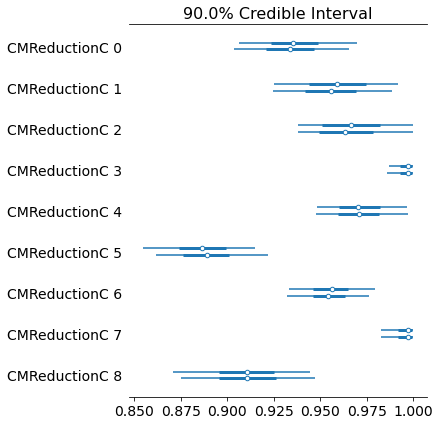

In [10]:
print("Cummulated CM effects")

a = trace['CMReduction']
def add_CM_to_CM(a, src, tgt):
    a[:, CMs.index(tgt)] *= a[:, CMs.index(src)]
add_CM_to_CM(a, "Gatherings limited to 1000", "Gatherings limited to 100")
add_CM_to_CM(a, "Gatherings limited to 100", "Gatherings limited to 10")
add_CM_to_CM(a, "Business suspended - some", "Business suspended - many")
trace.add_values({'CMReductionC': a}, True)

pm.forestplot(trace, var_names=['CMReductionC'], credible_interval=0.9)
for i, c in enumerate(CMs):
    print(f"{i:2} {c:40} CMReductionC {statstr(trace['CMReductionC'][:,i])}")

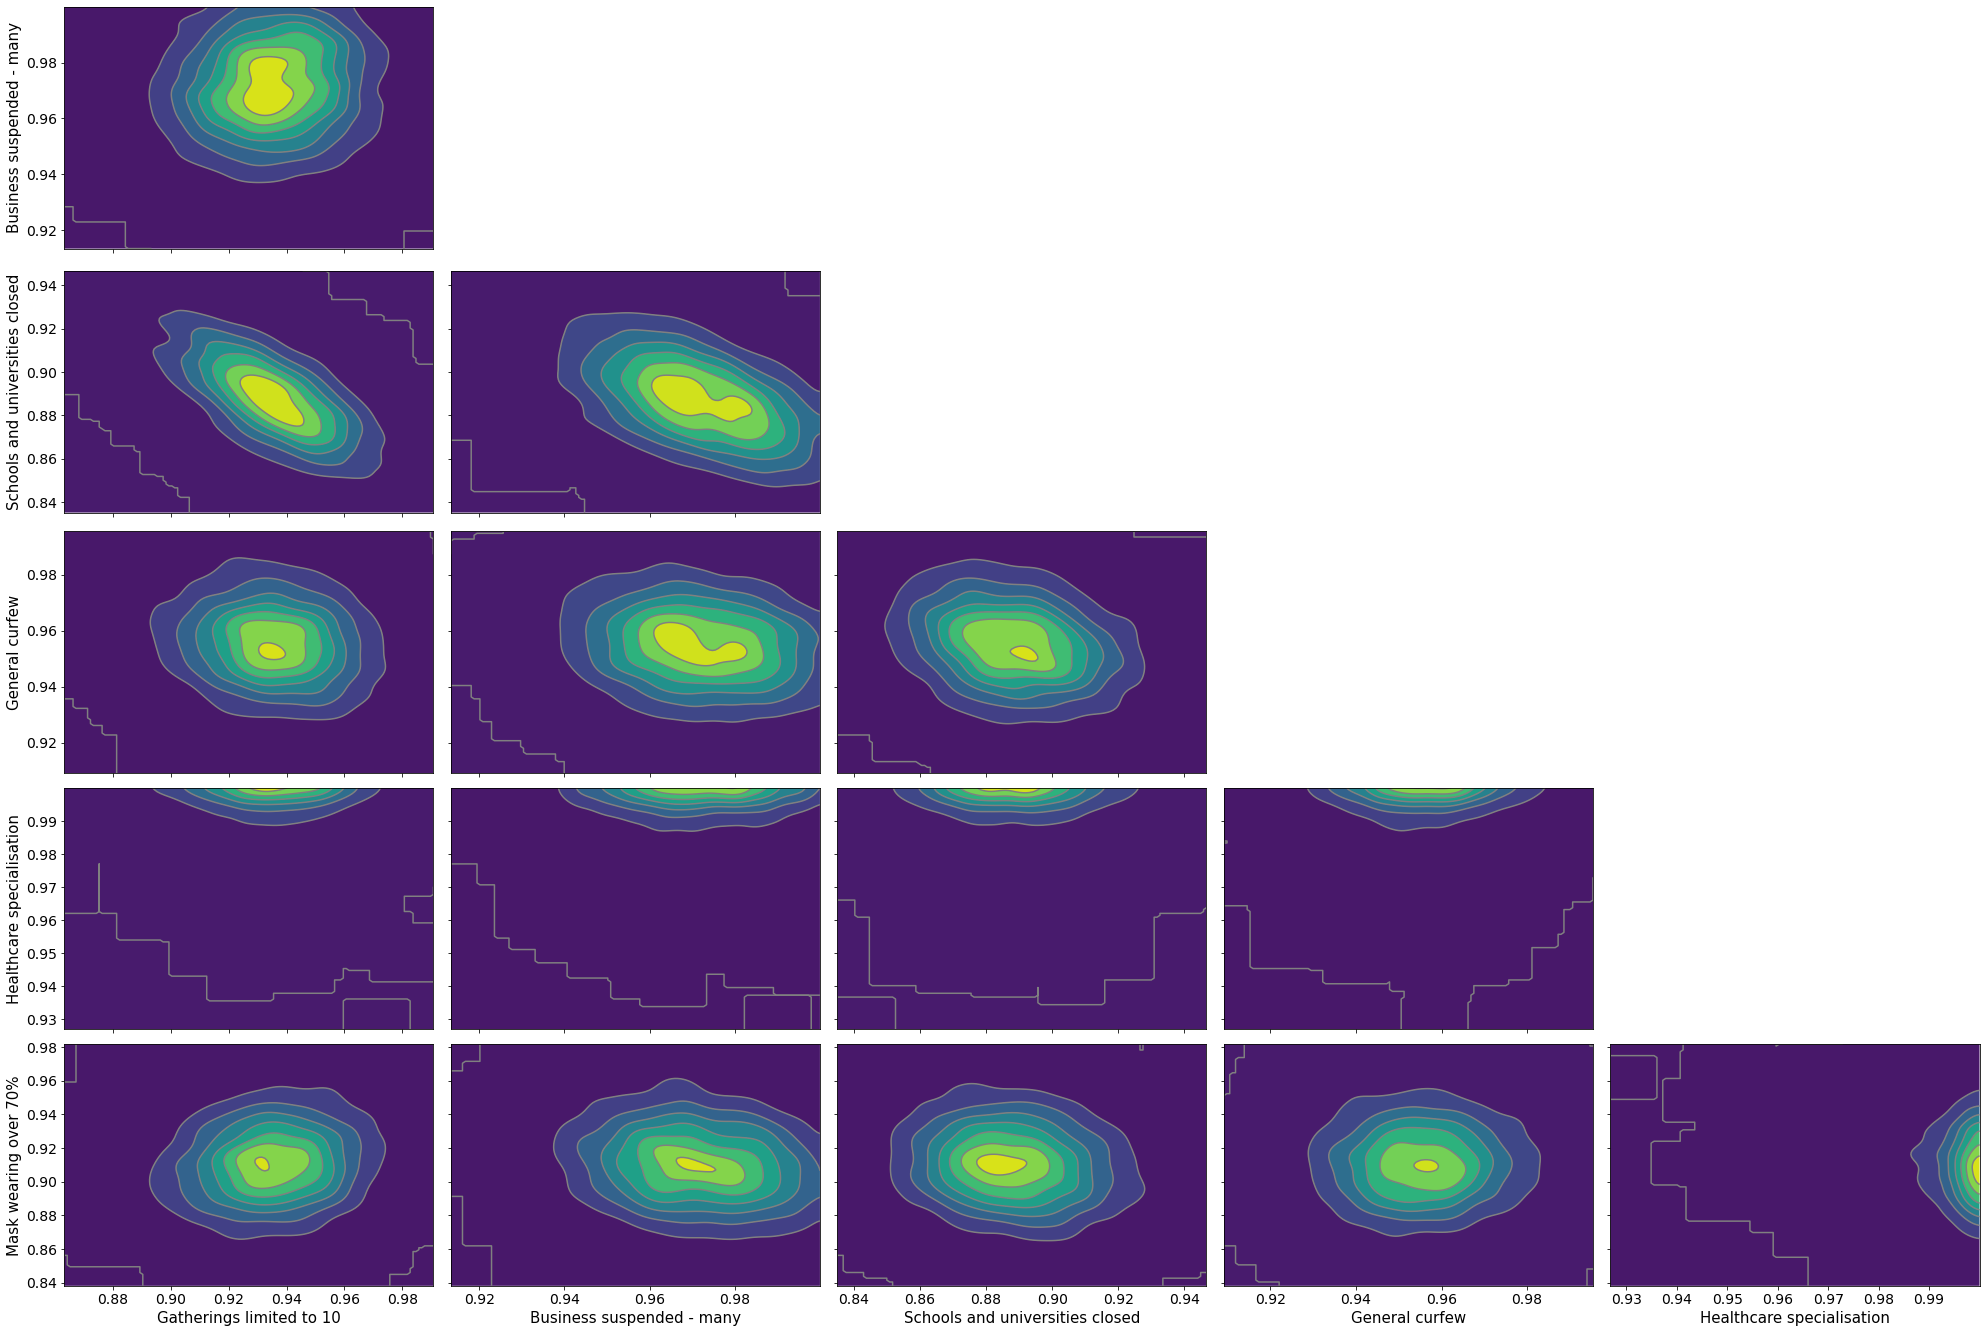

In [13]:
vs = []
for vn in ["Gatherings limited to 10", "Business suspended - many",
       "Schools and universities closed", "General curfew",
       "Healthcare specialisation", "Mask wearing over 70%"]:
    i = CMs.index(vn)
    vs.append(vn)
    trace.add_values({vn: trace['CMReductionC'][:, i]}, True)
_ = pm.plots.pairplot(trace, var_names=vs, kind='kde')

In [14]:
import plotly
from plotly import graph_objects as go
import plotly.express as px
import datetime

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
def plot_traces(data, name):
    fig = go.FigureWidget()
    fig.layout.title = go.layout.Title(text=name)
    for i, c in enumerate(Cs):
        d = data[:,i,:]
        color = (px.colors.qualitative.Dark24 * 10)[i]
        plot_line_CIs(fig, Ds, d, c, color)
    datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    fname = f'plot_{datestr}_{name}.html'
    plotly.io.write_html(fig, fname, include_plotlyjs='cdn')
    print(f"Wrote {fname}")
    return fig

In [15]:
plot_traces(np.exp(trace['DailyGrowth']), 'active_growth')

Wrote plot_2020-04-24_23-45-58_active_growth.html


FigureWidget({
    'data': [{'legendgroup': 'AD',
              'line': {'color': '#2E91E5'},
              'n…

In [16]:
plot_traces(np.exp(trace['Size']), 'active_confirmed')

Wrote plot_2020-04-24_23-46-01_active_confirmed.html


FigureWidget({
    'data': [{'legendgroup': 'AD',
              'line': {'color': '#2E91E5'},
              'n…